# Load External Dependencies
TODO: 
- Environment: (Consider scripting this in, esp. if I move it into colab)
    - All the imports should be in this section
- Data: move all paths up here, and a test to ensure the datasets load
    - Training Data: I won't be making this data public. There is too much, and most of it is not mine to share.
        - Custom Data: I highly encourage checking how well this generalizes!
    - Evaluation Data: I will include a couple of sample images in the repo, so that anyone can load the model and run with it
- Trained Models: 
    - TODO: I need to add these in a convenient way
        -This was created as a proof of concept, so I've got a mess of dependencies and local paths to clean up
- Re-think some naming conventions throughout this doc
- clean up the display images (lots of redundancy that was helpful during dev, but confusing now)
    - improve labels
- improve the TF implementations
    - could be a lot cleaner with built in train and eval functions

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

import glob
import time
import random

In [2]:
def validate_image_dir(src_dir, rich_print=True):
    """
    Purpose: Perform basic validation that the directory is valid.
    Considered valid if the directory contains at least 1 file. 
    Does NOT check extensions to verify files are images
    
    inputs:
        src_dir (string): directory to validate
        rich_print (bool): Whether to print a msg summarizing validation
    """
    good_image_paths = glob.glob(src_dir + '\*' )
    assert(len(good_image_paths) != 0)
    if rich_print:
        print(f"Found {len(good_image_paths)} files in in directory:\n{src_dir}")

passing_images_dir = r"C:\Users\OptimizePrime\Desktop\TrevorStuff\DataSets_TooBigForProjectRepos\WeldImages\ClevisWeld\Fail"
anomaly_images_dir = r"C:\Users\OptimizePrime\Desktop\TrevorStuff\DataSets_TooBigForProjectRepos\WeldImages\ClevisWeld\Pass"

validate_image_dir(passing_images_dir)
validate_image_dir(anomaly_images_dir)

Found 149 files in in directory:
C:\Users\OptimizePrime\Desktop\TrevorStuff\DataSets_TooBigForProjectRepos\WeldImages\ClevisWeld\Fail
Found 146 files in in directory:
C:\Users\OptimizePrime\Desktop\TrevorStuff\DataSets_TooBigForProjectRepos\WeldImages\ClevisWeld\Pass


All external dependencies should be loaded (so hopefully it's smooth sailing from here).

# Tools

TODO: Consider Moving "Tools" into 1 or more separate python files, and importing

In [3]:
def binarize(image, thresh=2000):
    """ 
    Creates a copy of the images, with binary thresholding. The return image will set
    pixels above 'thresh' to 'value'. 
    Original image will not be modified.
    
    Inputs:
        image: src image that threshold image will be based on
        thresh: image will be thresholded based on this value.
        value: All pixels below the thresh are set to 0, pixels above the thresh are set to value
        
    return:
        image: The return image will be a binary threshold of the input image, based on thresh
    """
    image = image.copy()
    
    idx = (image[:,:] < thresh)
    image[idx] = 0
    
    idx = (image[:,:] > thresh)
    image[idx] = 1
    
    return image

In [4]:
def limit(image, thresh):
    image = image.copy()
    
    idx = (image[:,:] > thresh)
    image[idx] = thresh
    
    return image

In [5]:
def crop(img, top, bottom, left, right):
    return img[top:bottom, left:right]

In [6]:
def generate_mean_image(images):
    return np.mean(images,axis=0)

In [7]:
def normalize_images(images, mean_image):
    return ( images / mean_image ) - 1.

In [8]:
def restore_images(images, mean_image):
    return np.array([(image+1)*mean_image for image in images])

# Display Tools

In [9]:
def show_image_grid(images, labels = None, intensity_range = None, im_size=1):
    """
    Purpose:
        Helper function for displaying multiple images together in a grid.
    
    Inputs:
        images: A grid of images (list of list of images, or 4D numpy array of [n_rows, n_cols, im_height, im_width].
            The display shape will match the input shape. All rows are expected to be the same length.
        labels: A grid of labels (shape must match images).
        intensity_range: list of [vmin, vmax]
            - This is useful if you wish all plots to use the same intensity scale.
        im_size: This can be used to scale images down. Most useful with 1-4 images, when they tend to scale up.
            - Warning: values >1 will prevent some data from being displayed, because the image grid will be
                       larger than the plot size allotted.
    
    Return: None
    """        
    
    images = np.array(images)
        
    if(len(images.shape) != 4):
        print("Error: Input shape of images is not correct. Ensure input is 4D: n_rows, n_cols, im_height, im_width")
        return False
    
    if(im_size > 1):
        print("*"*100)
        print("Warning: im_size > 1 in call to 'show_image_grid'. Some images may not be displaying. Consider using im_size <= 1.")
        print("*"*100)
    im_size *= 6
    
    n_rows, n_cols, im_height, im_width = images.shape
    
    show_title = True
    if(labels is None):
        show_title = False
        labels = np.zeros((n_rows, n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(im_size*n_cols,im_size*n_rows)) # (20/n_images, 20/n_images))

    axs = np.array(axs).reshape(n_rows, n_cols)
    for ax_row, img_row, label_row in zip(axs, images, labels):
        for ax, img, label in zip(ax_row, img_row, label_row):
            if intensity_range is None:
                ax.imshow(img)
            else:
                ax.imshow(img, vmin = intensity_range[0], vmax = intensity_range[1])

            if(show_title):
                ax.set_title(label)
                ax.title.set_fontsize(3*im_size)
            
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

# Load Images

TODO: Consider moving the function in this section to their own python file (the configuration should stay here though)

In [10]:
def read_grayscale_images(src_dir, dsize = (256, 256)):
    """
    Reading and preprocessing combined in one method because we're avoiding generators at the moment, and 
    some of the input images may be large. By reading and scaling down immediately, we can keep memory
    manageable. Long-term, I may convert to generator expressions, but that's really not the point of this
    excercise.
    """
    print('Loading and pre-processing images...')
    t = time.time()
    
    # Read in at standard size
    images = [ cv2.resize(cv2.imread(image_path), dsize) for image_path in glob.glob(src_dir + '\*' )] 
    
    # Grayscale
    images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]
    
    #Convert to numpy array
    images = np.array(images)
     
    print(f"Preprocessing complete in {time.time() - t}s.")
    
    return images

In [11]:
train_images = read_grayscale_images(passing_images_dir)
unfit_images = read_grayscale_images(anomaly_images_dir)

Loading and pre-processing images...
Preprocessing complete in 3.782003879547119s.
Loading and pre-processing images...
Preprocessing complete in 3.433032751083374s.


In [12]:
# Normalize Data (over each feature/pixel)
mean_image = generate_mean_image(train_images)

TODO: 
- Add Labels 
- Markdown block with explanation
- Pretty sure there's nothing special / different about the 4 images, so just show 1 (and then maybe transpose)

### Verify data below (this is a manual sanity check):
- First row should be passing/train data.
- Second row should be anamalous data.
- First and third columns should match, while center image should be a very neutral, normalized image.
    - This verifies that restore correctly reverses the normalize() operation.

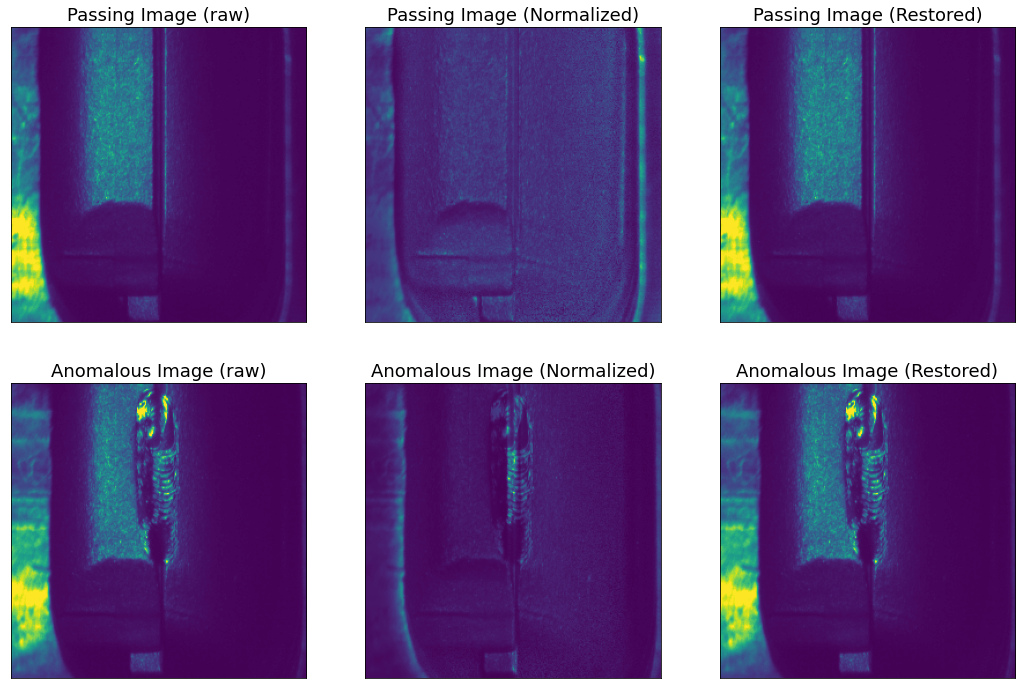

In [13]:
# Row 1 and 3 should match. Row 2 should be 'flattened in color space, due to the normalization.
passing_raw = train_images[0]
passing_norm = normalize_images(passing_raw, mean_image)
passing_restored = restore_images(np.expand_dims(passing_norm, 0), mean_image)

anomalous_raw = unfit_images[0]
anomalous_norm = normalize_images(anomalous_raw, mean_image)
anomalous_restored = restore_images(np.expand_dims(anomalous_norm, 0), mean_image)

grid_images = np.array([ [ passing_raw,   passing_norm,   passing_restored[0]   ],
                         [ anomalous_raw, anomalous_norm, anomalous_restored[0] ] ])


labels = [["Passing Image (raw)",   "Passing Image (Normalized)",   "Passing Image (Restored)"  ],
          ["Anomalous Image (raw)", "Anomalous Image (Normalized)", "Anomalous Image (Restored)"] ]

show_image_grid(grid_images, labels=labels)

# Model

TODO: Consider moving "Model" into separate file

In [14]:
class ConvNetAutoEncoder(tf.keras.Model):
    
    def __init__(self, image_channels=1):
        """
        image_channels: 1 for black and white
                        3 for standard color
                        >3 for hyperspectral
        """
        super(ConvNetAutoEncoder, self).__init__()
        
        self.conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu',
                     input_shape=(256, 256, image_channels))
        self.maxp1 = layers.MaxPooling2D(pool_size=(2, 2))
        self.conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.maxp2 = layers.MaxPooling2D(pool_size=(2, 2))
        self.conv3 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.maxp3 = layers.MaxPooling2D(pool_size=(2, 2))
        self.conv4 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        
        # Compressed / Bottleneck
        
        self.conv4_out = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.upsample3_out = layers.UpSampling2D(size=(2, 2))
        self.conv3_out = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.upsample2_out = layers.UpSampling2D(size=(2, 2))
        self.conv2_out = layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.upsample1_out = layers.UpSampling2D(size=(2, 2))
        self.conv1_out = layers.Conv2D(16, (3, 3), padding='same', activation='relu')
        self.channel_reducer = layers.Conv2D(image_channels, (1, 1), padding='same', activation='relu')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.maxp1(x)
        x = self.conv2(x)
        x = self.maxp2(x)
        x = self.conv3(x)
        x = self.maxp3(x)
        x = self.conv4(x)
        
        # x is Compressed / Bottleneck here
        x = self.conv4_out(x)
        x = self.upsample3_out(x)
        x = self.conv3_out(x)
        x = self.upsample2_out(x)
        x = self.conv2_out(x)
        x = self.upsample1_out(x)
        x = self.conv1_out(x)
        x = self.channel_reducer(x)
        return x
    

In [15]:
def loss(x, x_bar):
#     return np.mean(np.abs(result - original)) # L1 norm
#     return tf.losses.MAE(x, x_bar) # L1 norm
    return tf.losses.mean_squared_error(x, x_bar) # L2 norm

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        reconstruction = model(inputs)
        loss_value = loss(targets, reconstruction)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), reconstruction

# Train

TODO: 
    - This section has some nice manual methods...it's just that there's such clean ones already built-in,
consider switching over...It will make: this cleaner, the output cleaner, easier to add callbacks and metrics, etc.
    - Consider adding saving along the way, either periodically, or for best, and maybe add early stopping (with a high-ish patience)

TODO: Isn't this preprocessing? Why do I have it here?

In [16]:
# Data shape expect channel(s) included, even though there's only 1 grayscale channel - so reshape    
images = normalize_images(train_images, mean_image)
shape = images.shape
n_channels = 1
images = images.reshape(shape[0], shape[1], shape[2], n_channels)
print(images.shape)

(149, 256, 256, 1)


In [17]:
# Instantiate model - run to reset training
model = ConvNetAutoEncoder()
global_step = tf.Variable(0)

In [18]:
# Optimizer can be reset without resetting entire model (momentum for Adam resets though)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999)

In [19]:
# Train
num_epochs = 1 # Need at least 50 for any reasonable results, more is preferable
batch_size = 32
for epoch in range(num_epochs):
    t = time.time()
    print("Epoch: ", epoch)
    print("\tImage index (by batch): ", end='')
    for x in range(0, len(images), batch_size):
        x_inp = images[x : x + batch_size]
        loss_value, grads, reconstruction = grad(model, x_inp, x_inp)
        optimizer.apply_gradients(zip(grads, model.trainable_variables),
                              global_step)
        
        print("%d, " % (x), end = '')
#         if global_step.numpy() % 200 == 0:
#             pass
#             print("Step: {},         Loss: {}".format(global_step.numpy(),
#                                           loss(x_inp, reconstruction).numpy()))
        loss_list = loss(x_inp, reconstruction).numpy()
    print("\n\tLoss: {}\t\tdt: {} s".format(np.mean(loss_list),
                                            (time.time()-t)))
            

Epoch:  0
	Image index (by batch): WARNING:tensorflow:Layer conv_net_auto_encoder is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

0, 32, 64, 96, 128, 
	Loss: 2.7999095916748047		dt: 35.54050421714783 s


# Save and Load

In [20]:
model_name = os.path.join("models/", "trained_model")
# model.save(model_name) # TODO: reactivate before final run

In [21]:
model = tf.keras.models.load_model(model_name)
model.summary()

Model: "conv_net_auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple        

# Apply model and post-process results

In [22]:
def build_output_images(model, images, mean_image):
    """
    This runs the forward pass of the model on a set of images. Normalization, shaping, and 
    other details are handled internally
    
    Inputs:
        model: The trained model
        images: a list of images, matching the shape of the model input
        mean_image: Average of all images in the dataset (used for normalization)
        
    Return:
        Auto-Encoded image. This should preserve a large amount of data from the "passing" images,
        while losing most of the anomalous features.
    """
    
    # Normalize
    print("Normalizing...")
    images = normalize_images(images, mean_image)
    # Reshape
    print("Reshaping...")
    print(images.shape)
    shape = images.shape
    n_channels = 1
    images = images.reshape(shape[0], shape[1], shape[2], n_channels)

    # model (code and decode)
    print("Modeling...")
    images = model(images)
    
    # Reverse normalization, restoring original
    print("Restoring...")
    images = np.array(images[:,:,:,0])
    images = restore_images(images, mean_image)
    
    return images

In [23]:
print('Reconstructing trained images...')
reconstructions = build_output_images(model, train_images, mean_image) 

print('Reconstructing unfit images')
unfit_reconstructions = build_output_images(model, unfit_images, mean_image) 
# unfit_reconstructions = restore_images( model(unfit_images), mean_images)

print('Finished reconstructing images')

Reconstructing trained images...
Normalizing...
Reshaping...
(149, 256, 256)
Modeling...
Restoring...
Reconstructing unfit images
Normalizing...
Reshaping...
(146, 256, 256)
Modeling...
Restoring...
Finished reconstructing images


TODO:
- Looking back at this, the reconstruction picks up 2 things:
    - All high frequency information (makes sense, since my resizing/pooling destroys that anyways)
    - All unique features (eg: the welds)
- Consider leveraging the fact that all high frequency information is detected...
    - maybe pre-process with a low-pass filter(or just resize down to 256 for a similar effect)
    - I'm already doing an erode+dilate, but it's post-processing, and not quite the right way to ignore noise
- Again, using 4 samples, which was nice in dev, but kind of confusing to anybody else reading through now

## Visualize Results (with an example image)
- Showing 4 samples (1 sample per row), since each image performs a little differently. 
- each

In [24]:
def find_loss_image(image1, image2): 
    assert(image1.shape == image2.shape)
    height, width = image1.shape
    loss_image = loss(image1.reshape(height, width, 1), image2.reshape(height, width, 1)).numpy()
    return loss_image

In [25]:
# Filter out salt and pepper noise
# This style of model does downsample, and has a lot of trouble upsampling back to the original res...
# That means that the decompressed image will be blurred
def remove_salt_and_pepper_noise(image, kernel=(3,3), iterations=1):
    kernel = np.ones((2,2), np.uint8)
    
    eroded = cv2.erode(image, kernel, iterations=iterations)
    smoothed = cv2.dilate(eroded, kernel, iterations=iterations)
    
    return smoothed

In [155]:
# Image Processing Pipeline
class CropDims:
    def __init__(self, top, bottom, left, right):
        self.top = top
        self.bottom = bottom
        self.left = left
        self.right = right

def process_images(images, crop_dims=None, smoothing_kernel=None):
    """
    """
    if type(images) == list:
        images = np.array(images)
        print(f"Shape of images: {images.shape}")
        
    if smoothing_kernel:
        raw = remove_salt_and_pepper_noise(raw_passing, kernel=(3,3), iterations=1)

    print(images.shape)
    rebuilt_images = build_output_images(model, images, mean_image) 
    
    if crop_dims:
        c = crop_dims
        images = np.array([crop(image, c.top, c.bottom, c.left, c.right) for image in images])
        rebuilt_images = np.array([crop(image, c.top, c.bottom, c.left, c.right) for image in rebuilt_images])
    
    # diff_passing = cv2.absdiff(raw_passing, rebuilt_passing)
    loss_images = [find_loss_image(image, rebuilt) for image, rebuilt in zip(images,rebuilt_images)]
    
    return (images, rebuilt_images, loss_images)

In [156]:
crop_dims = CropDims(0,255,50,-25)

Shape of images: (1, 256, 256)
(1, 256, 256)
Normalizing...
Reshaping...
(1, 256, 256)
Modeling...
Restoring...
Trained Index: 	 103
Shape of images: (1, 256, 256)
(1, 256, 256)
Normalizing...
Reshaping...
(1, 256, 256)
Modeling...
Restoring...
Untrained Index: 	 72
Thresh: 7245.851392103138
Thresh 4357.771992252602


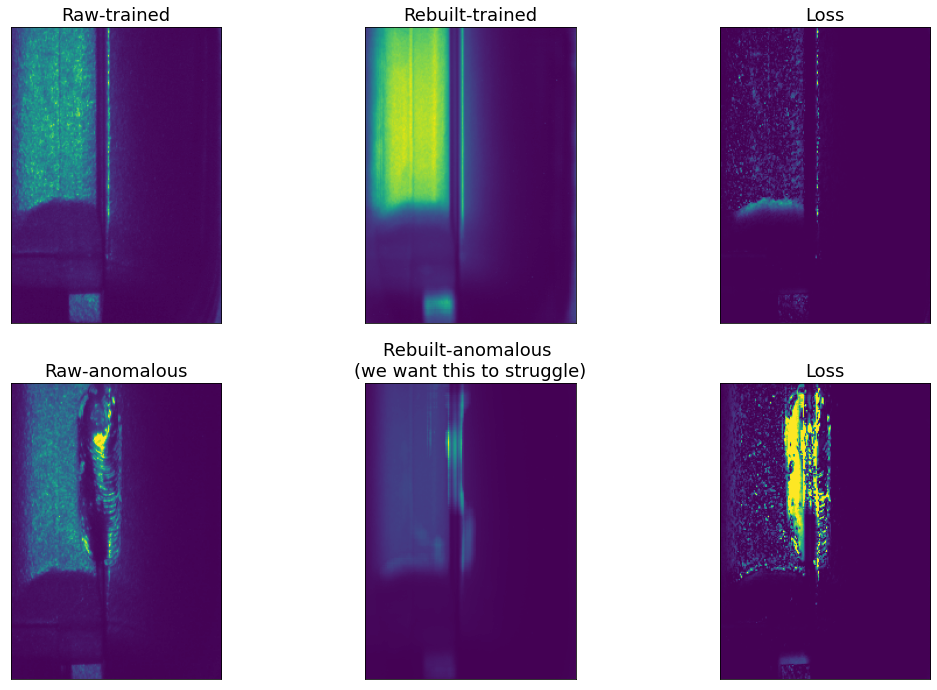

In [161]:
# Select random index
passing_index = random.randrange(0, len(images))
raw_passing = [np.array(train_images[passing_index])*1.]
(cropped_passing, rebuilt_passing, trained_loss) = process_images(raw_passing, crop_dims)
print("Trained Index: \t", passing_index)

anomalous_index = random.randrange(0, len(unfit_images))
raw_anomalous = [np.array(unfit_images[anomalous_index])*1.]
(cropped_anomalous,rebuilt_anomalous, unfit_loss) = process_images(raw_anomalous, crop_dims)
print("Untrained Index: \t", anomalous_index)


unfit_loss_flat = sorted(unfit_loss[0].flatten())
thresh = unfit_loss_flat[-500]
print("Thresh:", thresh)

trained_loss_flat = sorted(trained_loss[0].flatten())
thresh = trained_loss_flat[-10]
print("Thresh", thresh)

label_grid = [["Raw-trained", "Rebuilt-trained", "Loss"],
             ["Raw-anomalous", "Rebuilt-anomalous \n(we want this to struggle)", "Loss"]]

# Sanity check to make sure the images are sensible
image_grid = np.array([[cropped_passing[0], rebuilt_passing[0], limit(trained_loss[0], thresh)], 
                       [cropped_anomalous[0], rebuilt_anomalous[0], limit(unfit_loss[0], thresh)]])
show_image_grid(image_grid, label_grid)

#Index 71 is pretty good

4357.771992252602


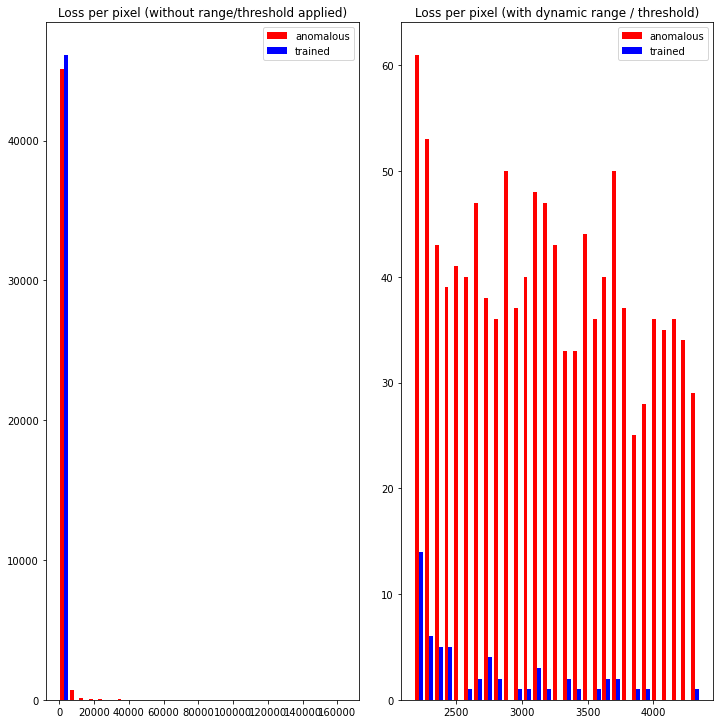

In [162]:
# Plot
# fig, axs  = plt.subplots(n_rows, n_cols, figsize=(im_size*n_cols,im_size*n_rows))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10) )
ax0, ax1 = axes.flatten()

fig.tight_layout()
data = [unfit_loss[0].flatten(), trained_loss[0].flatten()]
print(thresh)
colors = ['red','blue']
labels = ["anomalous", "trained"]

ax0.hist(data, 30, histtype='bar', color=colors, label=labels)
ax0.set_title('Loss per pixel (without range/threshold applied)')
ax0.legend(prop={'size': 10})

ax1.hist(data, np.linspace(thresh/2, thresh, 30), histtype='bar', color=colors, label=labels)
ax1.set_title('Loss per pixel (with dynamic range / threshold)')
ax1.legend(prop={'size': 10})

plt.show()


# TODO: Still not super happy with the denoising
- currently, I have a smoother on raw image for comparison (could even do that to training images, but haven't at the moment
    - currently smoothing the loss image prior to thresholding (not sure if that's great or not)
    - could smooth after threshold/binarization
    - Currently using erode/dilate to remove
- Could try a connected component search, deleting all clusters < 10 or so pixels
- could try this builtin cv2 func: new = cv2.fastNlMeansDenoising(trained_loss[0])

In [163]:
# trained_smoothed = remove_salt_and_pepper_noise(trained_loss, (2,2))
unfit_smoothed = remove_salt_and_pepper_noise(unfit_loss[0], (2,2))
trained_smoothed = remove_salt_and_pepper_noise(trained_loss[0], kernel=(2,2))

In [164]:
print(f"Threshold: {thresh}")
trained_loss_bin = binarize(trained_smoothed, thresh=thresh/3)*1000
anomalous_loss_bin = binarize(unfit_smoothed, thresh=thresh/3)*1000

Threshold: 4357.771992252602


In [165]:
# trained_loss_bin = remove_salt_and_pepper_noise(trained_loss_bin, kernel=(2,2))
# anomalous_loss_bin = remove_salt_and_pepper_noise(anomalous_loss_bin, kernel=(2,2))

TODO: Probably don't need this first one, but consider transferring the "Loss: #" label

Loss on trained image: 3.6832
Loss on unfit image: 53.2120
Unfit image missed 14.45 times as much information.


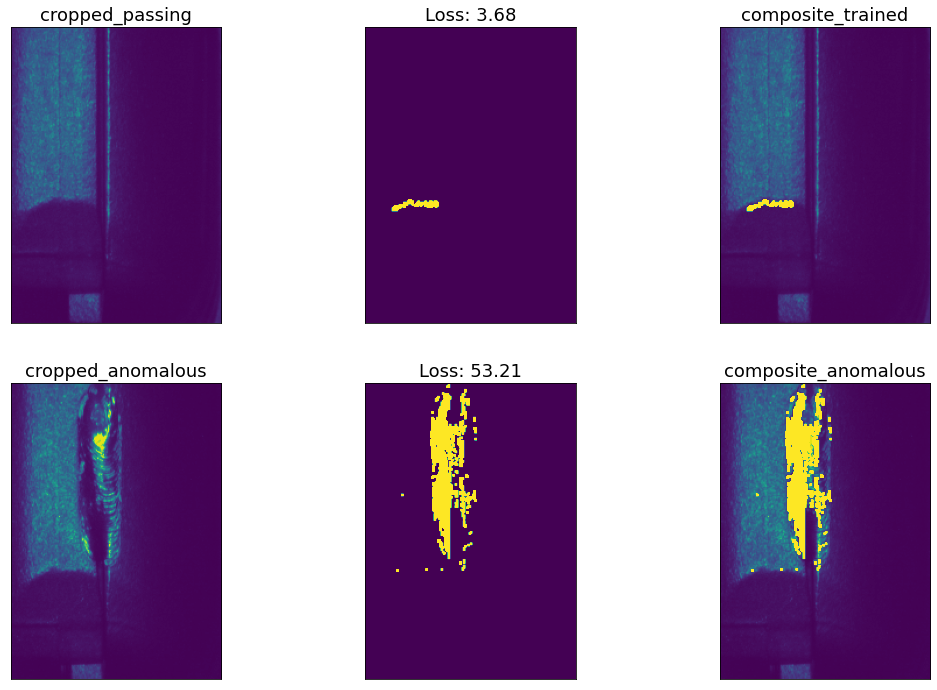

In [166]:
trained_mean_loss = np.mean(trained_loss_bin)
anomalous_mean_loss = np.mean(anomalous_loss_bin)

image_grid = [[cropped_passing[0], trained_loss_bin, cropped_passing[0]+trained_loss_bin],
              [cropped_anomalous[0], anomalous_loss_bin, cropped_anomalous[0]+anomalous_loss_bin]]

label_grid = [["cropped_passing", "Loss: %0.2f" % trained_mean_loss, "composite_trained"],
             ["cropped_anomalous", "Loss: %0.2f" % anomalous_mean_loss, "composite_anomalous"]]

print("Loss on trained image: %0.4f" % trained_mean_loss)
print("Loss on unfit image: %0.4f" % anomalous_mean_loss)
print("Unfit image missed %0.2f times as much information." % (anomalous_mean_loss/trained_mean_loss) ) 

show_image_grid(image_grid, label_grid, intensity_range=(0, anomalous_mean_loss*5)) 

# Summary and Analysis (Averaged over entire dataset)

In [175]:
images = normalize_images(train_images, mean_image)
shape = images.shape
images = images.reshape(shape[0], shape[1], shape[2], n_channels)

# This step could take a minute...generating all loss images
train_loss_images = loss(images, model(images)).numpy() 

In [176]:
images = normalize_images(unfit_images, mean_image)
shape = images.shape
images = images.reshape(shape[0], shape[1], shape[2], n_channels)

# This step could take a minute...generating all loss images
unfit_loss_images = loss(images, model(images)).numpy() 

In [179]:
train_loss_list = np.mean(train_loss_images,1)
anomaly_loss_list = np.mean(unfit_loss_images,1)

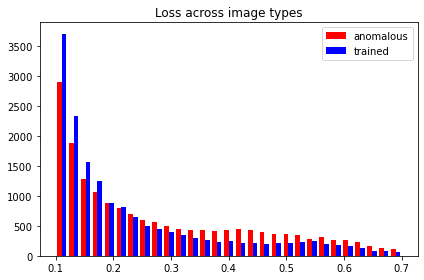

In [184]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=1)
ax = axes # ax = axes.flatten()

data = [anomaly_loss_list.flatten(), train_loss_list.flatten()]
bins = np.linspace(.1, .7, 30)
colors = ['red','blue']
labels = ["anomalous", "trained"]
ax.hist(data, bins, histtype='bar', color=colors, label=labels)

ax.set_title('Loss across image types')
ax.legend(prop={'size': 10})
fig.tight_layout()

plt.show()

# TODO: 
loss summary alone is not enough to distinguish...we need to binarize at a tunable threshold and then the 2 groups pop!

In [ ]:
print(loss_list.shape)
print(np.mean(loss_list))
print(np.std(loss_list))
thresh = np.mean(loss_list) + 3*np.std(loss_list)

anamolous_images = None
for index, i_loss in enumerate(loss_list):
    if i_loss > thresh:
        print(index, i_loss)
        images[index]
        if anamolous_images is None:
            anamolous_images = images[index][:,:,0]
        else:
            anamolous_images = np.array( [anamolous_images, images[index][:,:,0]])
#             anamolous_images = np.append(anamolous_images, images[index][:,:,0])
    
    
# np.reshapeanamolous_ima
print(np.array(anamolous_images).shape)
show_image_grid([restore_images(anamolous_images, mean_image)])
# show_image_grid([find_loss_image(anamolous_images, mean_image)])